In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import plot.viz_sequence as viz_sequence
from motif.tfmodisco_hit_scoring import import_tfmodisco_hits
from motif.read_motifs import pfm_to_pwm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np
import pandas as pd
import scipy.stats
import pyBigWig
import pyfaidx
import h5py
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
hit_key = "count"
hits_path = "/users/amtseng/tfmodisco/results/tfmodisco_hit_scoring/multitask_profile_finetune/REST_multitask_profile_finetune_task0_fold7_%s_halfsites/halfsites_only/tfm_matches.bed" % hit_key

profiles_hdf5_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/labels/REST/REST_profiles.h5"
exp_task_index = 0
cont_task_index = exp_task_index + 20
profile_length = 500

# Left half: TTCAGCACCG (+)
# Right half: TGGACAGCG (+)
if hit_key == "profile":
    left_key = "0_7"
    right_key = "0_1"
    left_swap_strands = True
    right_swap_strands = True
    left_adjust = (15, 0)
    right_adjust = (2, 2)
elif hit_key == "count":
    left_key = "0_8"
    right_key = "0_1"
    left_swap_strands = False
    right_swap_strands = True
    left_adjust = (5, 2)
    right_adjust = (2, 2)

rpm_norm_factor = 97789355  # Total number of reads in experiment

require_unique_config = True

In [4]:
reference_fasta_path = "/users/amtseng/genomes/hg38.fasta"

In [5]:
out_path = "/users/amtseng/tfmodisco/figures/rest_motif_spacing/"
os.makedirs(out_path, exist_ok=True)

### Helper functions

In [6]:
def dna_to_one_hot(seqs, out_dtype=np.float64):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    `out_dtype` can be altered to change the datatype of the output one-hot
    sequences. By default, this is `np.float64`, but may be changed to other
    types (e.g. using `out_dtype=np.int8` will drastically reduce memory usage).
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(out_dtype)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [7]:
def get_binding_strength(
    coords, profiles_hdf5_path, exp_task_index, cont_task_index, profile_length
):
    """
    For the given coordinates as an N x 3 object array (or list of triples),
    obtains the strength of binding as the total read count (averaged over
    strands) in the interval of length `profile_length` surrounding that
    coordinate. Returns an N-array of total read counts, and a parallel
    N-array of total read counts for the control.
    """
    exp_counts, cont_counts = np.empty(len(coords)), np.empty(len(coords))
    
    with h5py.File(profiles_hdf5_path, "r") as f:
        for i in tqdm.notebook.trange(len(coords)):
            chrom, start, end = coords[i]
            mid = (start + end) // 2
            
            prof_start = mid - (profile_length // 2)
            prof_end = prof_start + profile_length
            
            profiles = f[chrom][prof_start:prof_end]
            exp_counts[i] = np.mean(np.sum(profiles[:, exp_task_index], axis=0))
            cont_counts[i] = np.mean(np.sum(profiles[:, cont_task_index], axis=0))
    return exp_counts, cont_counts

In [8]:
def find_left_right_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a left-half and right-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 1:
                continue
        
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = right_row["start"] - left_row["end"], (left_row["start"], right_row["end"])
                else:
                    dist, coord = left_row["start"] - right_row["end"], (right_row["start"], left_row["end"])
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [9]:
def find_right_left_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a right-half and left-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 1:
                continue
        
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = left_row["start"] - right_row["end"], (right_row["start"], left_row["end"])
                else:
                    dist, coord = right_row["start"] - left_row["end"], (left_row["start"], right_row["end"])
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [10]:
def find_full_left_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a canonical full and left-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 2 or len(right_rows) != 1:
                continue
        else:
            if len(left_rows) < 2 or len(right_rows) < 1:
                continue
        
        # First, find all full canonical motifs
        full_coords = []
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+" and left_row["end"] == right_row["start"]:
                    full_coords.append((left_row["start"], right_row["end"]))
                elif strand == "-" and right_row["end"] == left_row["start"]:
                    full_coords.append((right_row["start"], left_row["end"]))
        
        # Next, find the half motif after each full motif
        for full_start, full_end in full_coords:
            for _, left_row in left_rows.iterrows():
                if strand == "+":
                    dist, coord = left_row["start"] - full_end, (full_start, left_row["end"])
                else:
                    dist, coord = full_start - left_row["end"], (left_row["start"], full_end)
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

In [11]:
def find_full_right_instances(subtable, require_unique_config=False):
    """
    From a subtable of a hits table, limited to a single peak, finds if there
    is a canonical full and right-half in that order, and returns the coordinate
    and distance between. If there are multiple possible pairs, takes the one
    with the shortest distance between.
    None is returned for the coordinate if no such match is found.
    """
    min_dist, min_coord = float("inf"), None
    chrom = subtable["chrom"].values[0]
    
    for strand in np.unique(subtable["strand"]):
        left_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == left_key)]
        right_rows = subtable[(subtable["strand"] == strand) & (subtable["key"] == right_key)]
        
        if require_unique_config:
            if len(left_rows) != 1 or len(right_rows) != 2:
                continue
        else:
            if len(left_rows) < 1 or len(right_rows) < 2:
                continue
        
        # First, find all full canonical motifs
        full_coords = []
        for _, left_row in left_rows.iterrows():
            for _, right_row in right_rows.iterrows():
                if strand == "+" and left_row["end"] == right_row["start"]:
                    full_coords.append((left_row["start"], right_row["end"]))
                elif strand == "-" and right_row["end"] == left_row["start"]:
                    full_coords.append((right_row["start"], left_row["end"]))
        
        # Next, find the half motif after each full motif
        for full_start, full_end in full_coords:
            for _, right_row in right_rows.iterrows():
                if strand == "+":
                    dist, coord = right_row["start"] - full_end, (full_start, right_row["end"])
                else:
                    dist, coord = full_start - right_row["end"], (right_row["start"], full_end)
                if dist >= 0 and dist < min_dist:
                    min_dist, min_coord = dist, coord
        
    return (chrom, min_coord[0], min_coord[1]) if min_coord else None, min_dist

### REST motif spacing

In [12]:
# Import motif hits for left and right halves
hit_table = import_tfmodisco_hits(hits_path)

# Trim to the motif hits to a canonical size and strand:
# This way, the canonical motif is with a spacer of 0 bp
new_strands = np.full(len(hit_table), "")
new_starts = np.zeros(len(hit_table), dtype=int)
new_ends = np.zeros(len(hit_table), dtype=int)

left_pos_mask = (hit_table["key"] == left_key) & (hit_table["strand"] == "+")
new_strands[left_pos_mask] = "-" if left_swap_strands else "+"
new_starts[left_pos_mask] = hit_table[left_pos_mask]["start"] + left_adjust[0]
new_ends[left_pos_mask] = hit_table[left_pos_mask]["end"] - left_adjust[1]
left_neg_mask = (hit_table["key"] == left_key) & (hit_table["strand"] == "-")
new_strands[left_neg_mask] = "+" if left_swap_strands else "-"
new_starts[left_neg_mask] = hit_table[left_neg_mask]["start"] + left_adjust[1]
new_ends[left_neg_mask] = hit_table[left_neg_mask]["end"] - left_adjust[0]

right_pos_mask = (hit_table["key"] == right_key) & (hit_table["strand"] == "+")
new_strands[right_pos_mask] = "-" if right_swap_strands else "+"
new_starts[right_pos_mask] = hit_table[right_pos_mask]["start"] + right_adjust[0]
new_ends[right_pos_mask] = hit_table[right_pos_mask]["end"] - right_adjust[1]
right_neg_mask = (hit_table["key"] == right_key) & (hit_table["strand"] == "-")
new_strands[right_neg_mask] = "+" if right_swap_strands else "-"
new_starts[right_neg_mask] = hit_table[right_neg_mask]["start"] + right_adjust[1]
new_ends[right_neg_mask] = hit_table[right_neg_mask]["end"] - right_adjust[0]

hit_table["strand"] = new_strands
hit_table["start"] = new_starts
hit_table["end"] = new_ends

0it [00:00, ?it/s]

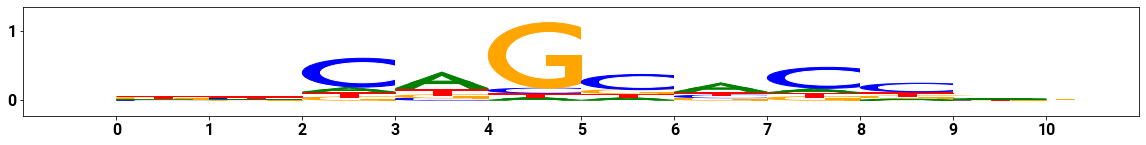

0it [00:00, ?it/s]

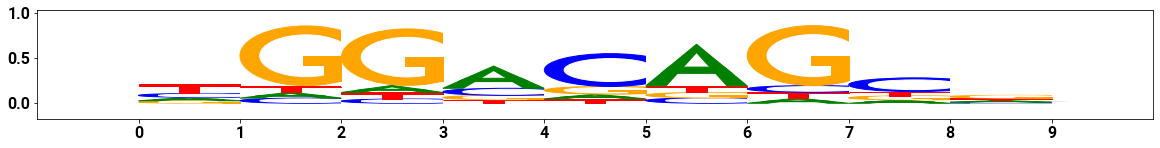

In [13]:
# Verify trimming/orienting was done correctly
# We should see the following motifs:
# Left half: TTCAGCACCG (+)
# Right half: TGGACAGCG (+)
def show_pfm(key):
    genome_reader = pyfaidx.Fasta(reference_fasta_path)
    seqs = []
    for _, row in tqdm.notebook.tqdm(hit_table[(hit_table["key"] == key) & (hit_table["strand"] == "+")].iterrows()):
        seqs.append(genome_reader[row["chrom"]][row["start"]:row["end"]].seq)
    one_hots = dna_to_one_hot(seqs)
    pfm = np.sum(one_hots, axis=0)
    pfm = pfm / np.sum(pfm, axis=1, keepdims=True)
    viz_sequence.plot_weights(pfm_to_pwm(pfm))
    
show_pfm(left_key)
show_pfm(right_key)

In [14]:
# Collapse motifs properly, using trimmed motifs
trimmed_hits_path = os.path.join(out_path, "hits_trimmed.bed")
collapsed_hits_path = os.path.join(out_path, "hits_trimmed_collapsed.bed")

# Write trimmed motifs to file
hit_table.to_csv(trimmed_hits_path, sep="\t", header=False, index=False)

# Collapse trimmed motifs when there is at least 1 bp overlapping
!python /users/amtseng/tfmodisco/src/motif/collapse_motif_hits.py {trimmed_hits_path} 7 -s -d -1 > {collapsed_hits_path}

# Import collapsed motif hits
hit_table = import_tfmodisco_hits(collapsed_hits_path)

In [15]:
# Iterating through peaks, find instances of configurations of interest
left_right_coords, left_right_dists = [], []
right_left_coords, right_left_dists = [], []
full_left_coords, full_left_dists = [], []
full_right_coords, full_right_dists = [], []

for peak_index, subtable in tqdm.notebook.tqdm(hit_table.groupby("peak_index")):
    num_left = np.sum(subtable["key"] == left_key)
    num_right = np.sum(subtable["key"] == right_key)
    
    left_right_coord, left_right_dist = find_left_right_instances(subtable, require_unique_config)
    if left_right_coord:
        left_right_coords.append(left_right_coord)
        left_right_dists.append(left_right_dist)
    
    right_left_coord, right_left_dist = find_right_left_instances(subtable, require_unique_config)
    if right_left_coord:
        right_left_coords.append(right_left_coord)
        right_left_dists.append(right_left_dist)

    full_left_coord, full_left_dist = find_full_left_instances(subtable, require_unique_config)
    if full_left_coord:
        full_left_coords.append(full_left_coord)
        full_left_dists.append(full_left_dist)
        
    full_right_coord, full_right_dist = find_full_right_instances(subtable, require_unique_config)
    if full_right_coord:
        full_right_coords.append(full_right_coord)
        full_right_dists.append(full_right_dist)
        
left_right_dists = np.array(left_right_dists)
right_left_dists = np.array(right_left_dists)
full_left_dists = np.array(full_left_dists)
full_right_dists = np.array(full_right_dists)

  0%|          | 0/4611 [00:00<?, ?it/s]

In [16]:
# Extract binding strength at each coordinate of interest
left_right_exp_scores, left_right_cont_scores = get_binding_strength(left_right_coords, profiles_hdf5_path, exp_task_index, cont_task_index, profile_length)
right_left_exp_scores, right_left_cont_scores = get_binding_strength(right_left_coords, profiles_hdf5_path, exp_task_index, cont_task_index, profile_length)
full_left_exp_scores, full_left_cont_scores = get_binding_strength(full_left_coords, profiles_hdf5_path, exp_task_index, cont_task_index, profile_length)
full_right_exp_scores, full_right_cont_scores = get_binding_strength(full_right_coords, profiles_hdf5_path, exp_task_index, cont_task_index, profile_length)

  0%|          | 0/1432 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

In [17]:
def normalize_binding_strength(exp_scores, cont_scores):
    return exp_scores - cont_scores

left_right_scores = normalize_binding_strength(left_right_exp_scores, left_right_cont_scores)
right_left_scores = normalize_binding_strength(right_left_exp_scores, right_left_cont_scores)
full_left_scores = normalize_binding_strength(full_left_exp_scores, full_left_cont_scores)
full_right_scores = normalize_binding_strength(full_right_exp_scores, full_right_cont_scores)

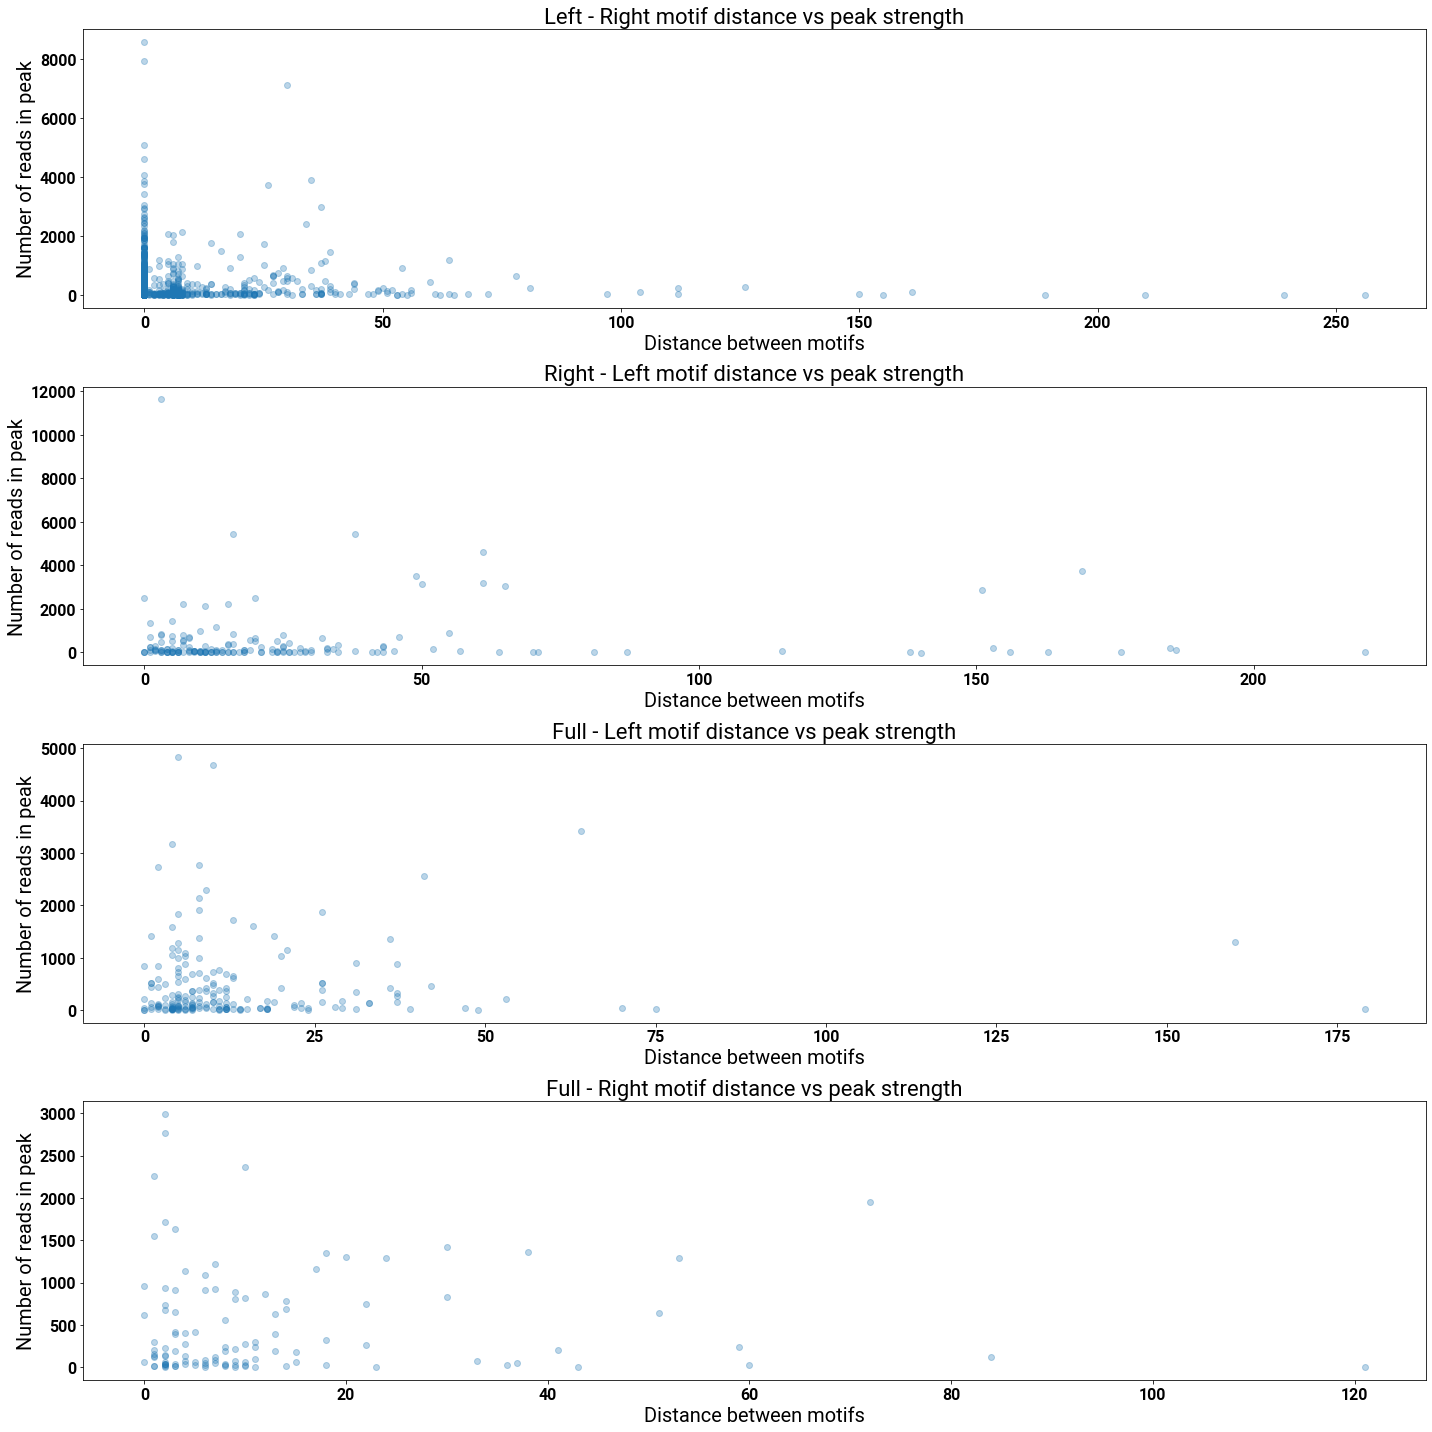

In [18]:
# Plot correspondence between binding strength and distance as a scatterplot
fig, ax = plt.subplots(nrows=4, figsize=(20, 20))
ax[0].scatter(left_right_dists, left_right_scores, alpha=0.3)
ax[0].set_title("Left - Right motif distance vs peak strength")
ax[1].scatter(right_left_dists, right_left_scores, alpha=0.3)
ax[1].set_title("Right - Left motif distance vs peak strength")
ax[2].scatter(full_left_dists, full_left_scores, alpha=0.3)
ax[2].set_title("Full - Left motif distance vs peak strength")
ax[3].scatter(full_right_dists, full_right_scores, alpha=0.3)
ax[3].set_title("Full - Right motif distance vs peak strength")

for i in range(4):
    ax[i].set_xlabel("Distance between motifs")
    ax[i].set_ylabel("Number of reads in peak")
    
fig.tight_layout()
plt.show()

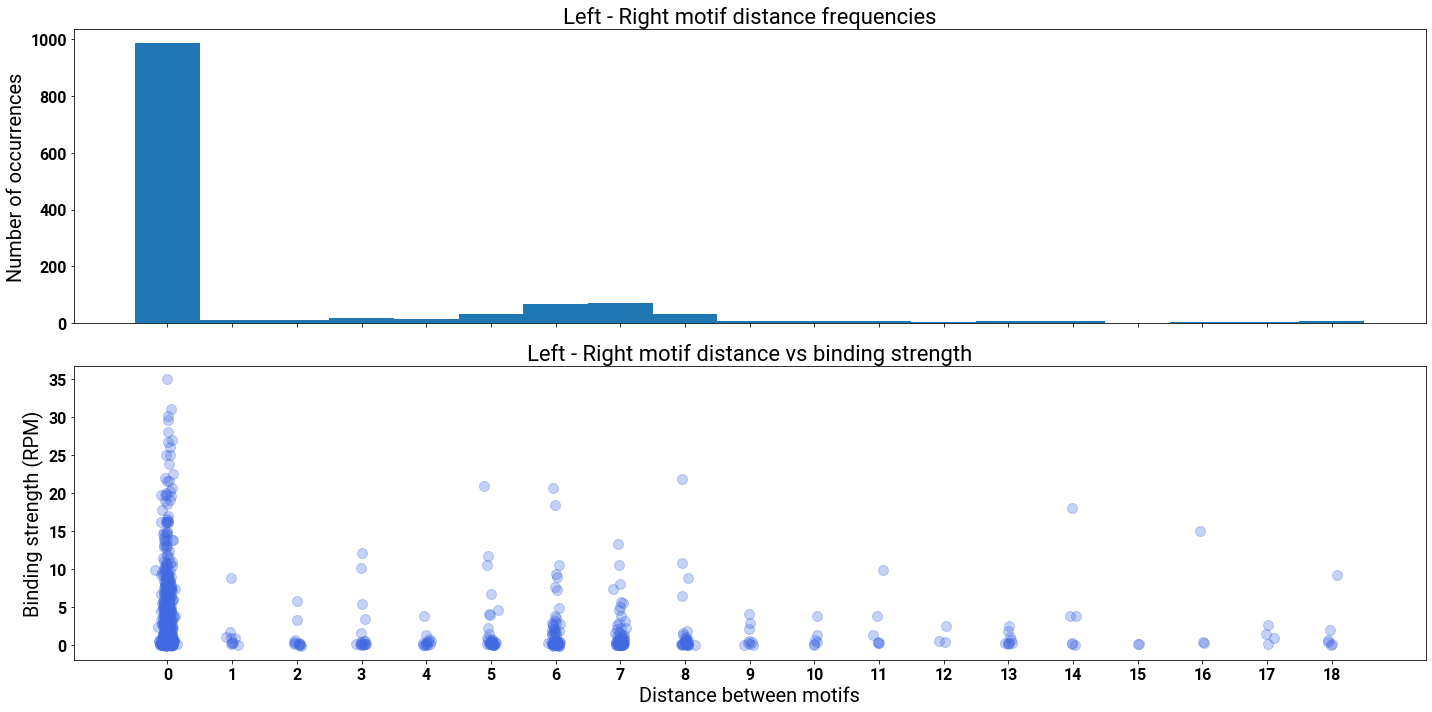

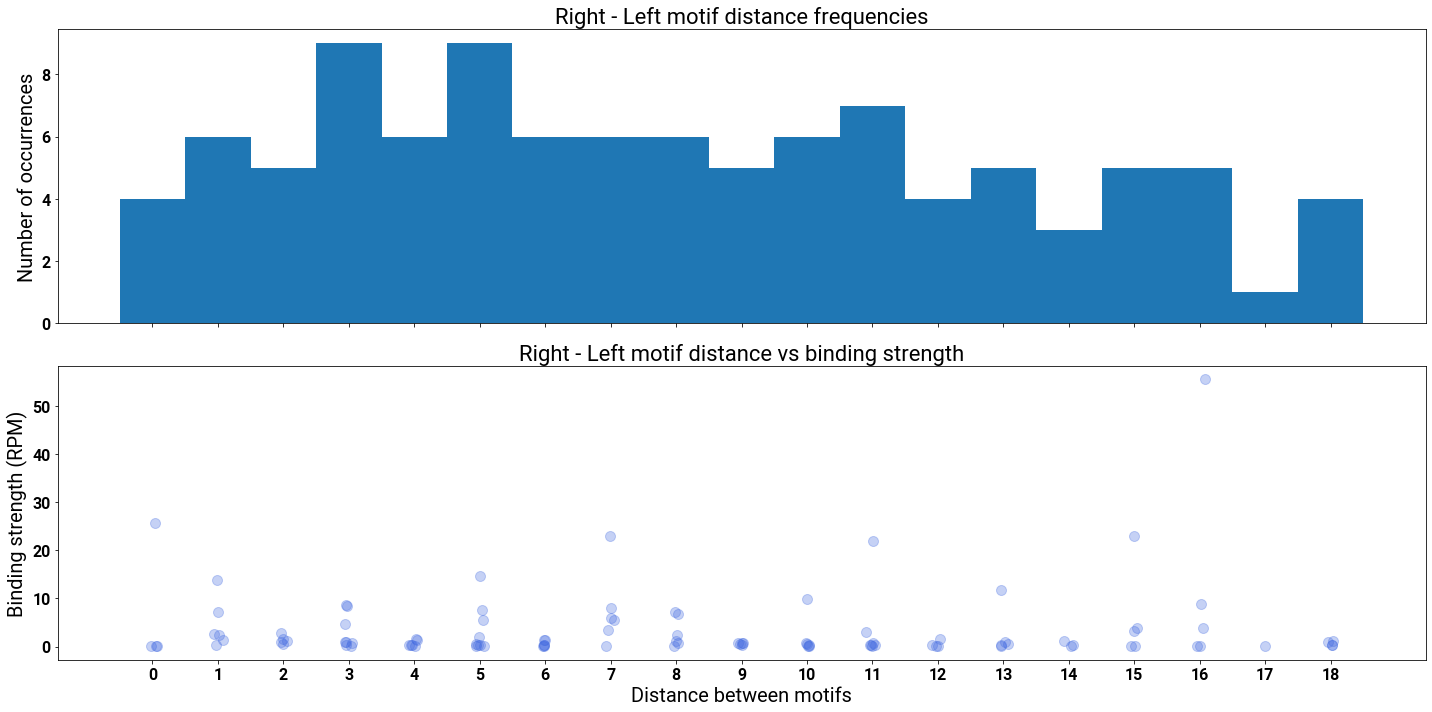

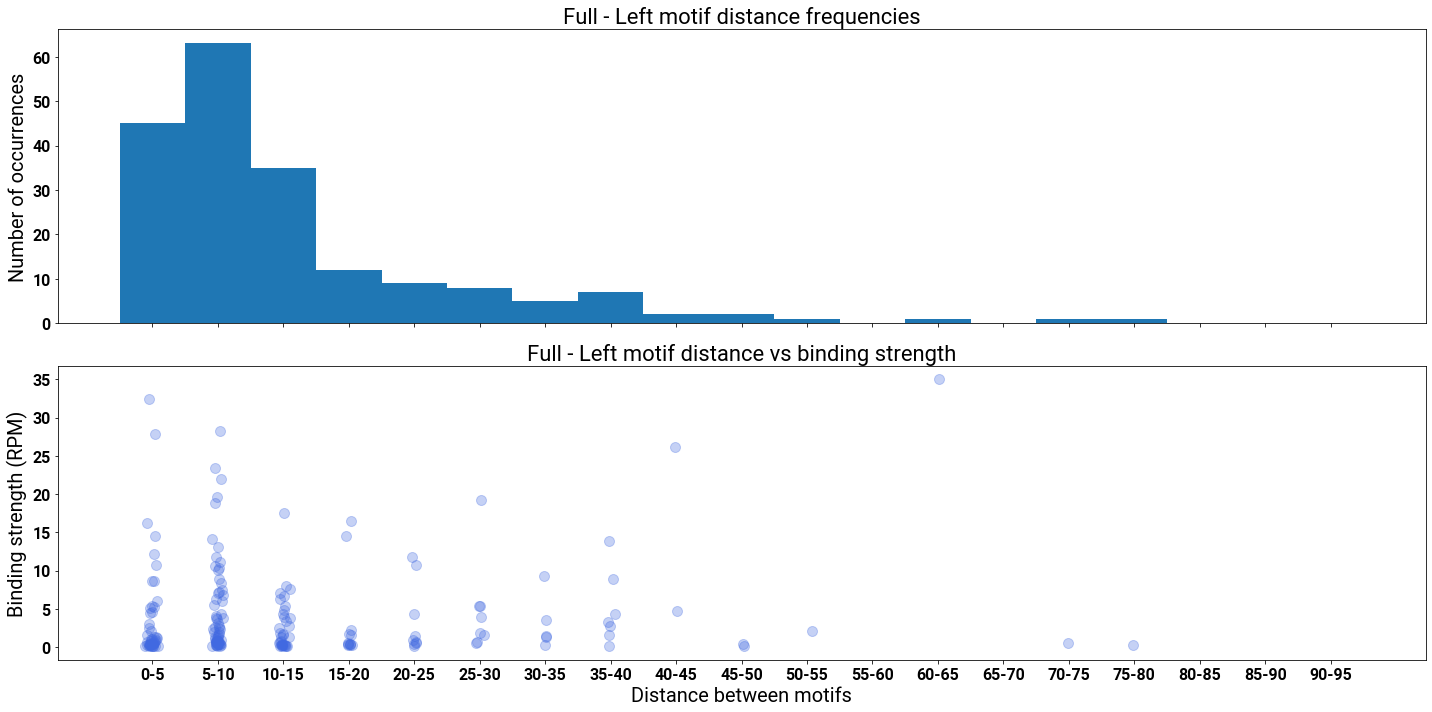

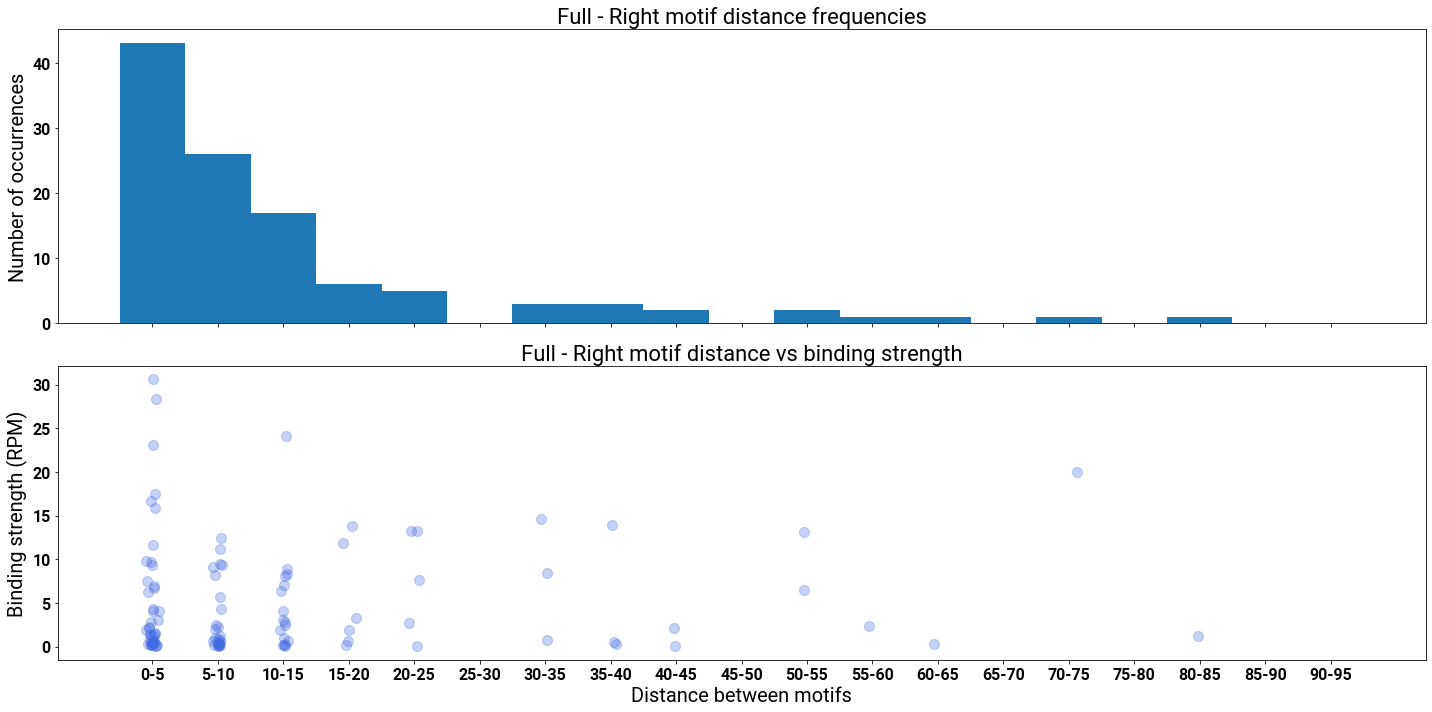

In [19]:
# Plot distance vs frequency, and distance vs binding strength
def plot_frequency_and_strength(dists, scores, bins, cond_name, save_path=None):
    fig, ax = plt.subplots(nrows=2, figsize=(20, 10), sharex=True)
    
    # Normalize scores into RPMs:
    scores = scores / rpm_norm_factor * 1e6
    
    all_bin_counts, all_bin_scores, labels = [], [], []
    for i in range(len(bins) - 1):
        start, end = bins[i], bins[i + 1]
        mask = (dists >= start) & (dists < end)
        all_bin_counts.append(np.sum(mask))
        all_bin_scores.append(scores[mask])
        if end - start == 1:
            labels.append(str(start))
        else:
            labels.append("%d-%d" % (start, end))
    
    score_mean, score_std = np.mean(scores), np.std(scores)
    outlier_thresh = score_mean + (5 * score_std)
    
    ax[0].bar(labels, all_bin_counts, 1)
    ax[0].set_title("%s motif distance frequencies" % cond_name)
    ax[0].set_ylabel("Number of occurrences")
    ax[0].set_xticks([])
        
    for i, bin_scores in enumerate(all_bin_scores):
        bin_scores_filtered = bin_scores[bin_scores < outlier_thresh]
        x = np.random.normal(i, 0.04, len(bin_scores_filtered))
        ax[1].scatter(x, bin_scores_filtered, alpha=0.3, color="royalblue", s=100, zorder=1)
    
    ax[1].set_xticks(np.arange(len(labels)))
    ax[1].set_xticklabels(labels)
    ax[1].set_xlabel("Distance between motifs")
    ax[1].set_ylabel("Binding strength (RPM)")
    ax[1].set_title("%s motif distance vs binding strength" % cond_name)
    
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format="svg")
    plt.show()
    
plot_frequency_and_strength(left_right_dists, left_right_scores, np.arange(0, 20, 1), "Left - Right", os.path.join(out_path, "left_right.svg"))
plot_frequency_and_strength(right_left_dists, right_left_scores, np.arange(0, 20, 1), "Right - Left", os.path.join(out_path, "right_left.svg"))
plot_frequency_and_strength(full_left_dists, full_left_scores, np.arange(0, 100, 5), "Full - Left", os.path.join(out_path, "full_left.svg"))
plot_frequency_and_strength(full_right_dists, full_right_scores, np.arange(0, 100, 5), "Full - Right", os.path.join(out_path, "full_right.svg"))